# Monthly Baseline 2: Moving Average (Sum of Next 4 Weeks)

This notebook implements the Moving Average baseline model for forecasting the **sum of the next 4 weeks** (monthly respiratory-morbidity rates) in Brazilian municipalities.

- **Model:** Moving Average Baseline
- **Target:** Sum of next 4 weeks (monthly forecast)
- **Formula:** ŷ(t) = soma(t−n:t−1), com n = 4
- **Purpose:** Serve as a simple, interpretable benchmark for more complex models.
- **All code is modular and imported from `src/` modules.**


In [ ]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"Project root: {project_root}")

# Add the project root to sys.path (not the src directory)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to sys.path")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import functions from src modules
from src.preprocessing import load_city_data, load_all_cities, prepare_data_for_model, filter_city, clean_timeseries
from src.models import MovingAverageBaseline
from src.train import evaluate_model, generate_forecasts, save_predictions, save_metrics
from src.utils import plot_forecast, plot_forecast_error, plot_training_history

# Set up results directory
results_dir = os.path.join('results', 'moving_average_baseline')
os.makedirs(results_dir, exist_ok=True)

np.random.seed(42)


## Repository Structure

- **data/**: One CSV per city, each with a date column, target column, and optional features (e.g., climate, GHG emissions).
- **notebooks/**: Jupyter notebooks for each experiment. Notebooks are for visualization and exploration only.
- **src/**: Reusable Python modules:
    - `preprocessing.py`: Data loading, normalization, train/test split, sequence/window creation
    - `models.py`: Model definitions (baselines, MLP, LSTM, GRU, CNN, etc.)
    - `train.py`: Training and evaluation routines (callbacks, metrics logging, early stopping)
    - `utils.py`: Helper functions (plotting, custom metrics, inverse transforms)
- **results/**: Saved forecasts and evaluation metrics for each city/model.
- **instructions.md**: Best-practices guide for AI assistants and contributors.

**All core logic lives in `src/`. Notebooks import and orchestrate these functions.**


## Data Loading and Exploration

Load the respiratory morbidity data for analysis. You can loop over all cities or select a specific city for demonstration.

In [2]:
# Example: Load data for one city (replace with actual city file as needed)
data_path = '../data/df_base_morb_resp.csv'  # Example file, update as needed
df = load_city_data(data_path)

# Display the data
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6684000, 11)


,CD_MUN,week,target,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
0,1100015,0,0.515856,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
1,1100015,1,0.539765,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
2,1100015,2,0.458823,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
3,1100015,3,0.485555,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
4,1100015,4,0.231805,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39


In [3]:
# Display column information
print("Columns in the dataset:")
print(df.columns.tolist())

# Display basic statistics
df.describe()

Columns in the dataset:
['CD_MUN', 'week', 'target', 'PIB', 'DENS', 'URB', 'CO2', 'CH4', 'N2O', 'LAT', 'LON']


,CD_MUN,week,target,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
count,6.684000e+06,6.684000e+06,6.684000e+06,6.003816e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06,6.033600e+06
mean,3.253591e+06,5.995000e+02,4.710729e-01,1.397299e+04,8.091379e+01,1.268524e-02,3.953797e+04,7.463403e+02,1.116126e+01,-1.638302e+01,-4.637996e+01
std,9.848220e+05,3.464101e+02,3.616928e+00,1.973538e+04,3.952444e+02,4.668693e-02,1.244388e+05,1.332048e+04,2.845796e+01,8.354524e+00,6.424812e+00
min,1.100015e+06,0.000000e+00,0.000000e+00,-1.459830e+03,3.143629e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.365254e+01,-7.348400e+01
25%,2.512101e+06,2.997500e+02,0.000000e+00,4.516650e+03,1.112562e+01,1.319166e-03,4.454221e+03,6.922971e+01,4.712564e+00,-2.279264e+01,-5.102275e+01
50%,3.146280e+06,5.995000e+02,0.000000e+00,8.607535e+03,2.363456e+01,2.999792e-03,1.128696e+04,1.379897e+02,8.660524e+00,-1.785337e+01,-4.661550e+01
75%,4.119202e+06,8.992500e+02,2.773210e-01,1.684539e+04,4.817254e+01,7.148583e-03,2.817704e+04,2.405503e+02,1.352129e+01,-8.456431e+00,-4.166000e+01
max,5.300108e+06,1.199000e+03,7.359496e+02,9.208340e+05,1.344249e+04,9.768962e-01,3.137265e+06,7.075641e+05,3.683565e+03,4.685425e+00,-3.487000e+01


## Data Preprocessing

Prepare the data for the Moving Average baseline model. Set the window size (n=4) and select the target column.

In [4]:
# Define parameters
model_params = {
    'sequence_length': 8,  # Look back window for sequence creation (not used by moving average directly)
    'forecast_horizon': 4,  # Predict sum of next 4 weeks (monthly forecast)
    'normalization': None   # No normalization for baseline
}

target_column = 'target'

# Prepare the data for the model
data_dict = prepare_data_for_model(
    df=df,
    target_column=target_column,
    sequence_length=model_params['sequence_length'],
    forecast_horizon=model_params['forecast_horizon'],
    normalization=model_params['normalization']
)

X_test = data_dict['X_test']
y_test = data_dict['y_test']
test_df = data_dict['test_df']


## Define and Run the Moving Average Baseline Model

The Moving Average Baseline predicts the **sum of the last 4 values** in the input window (to match the sum-of-4-weeks target). This ensures predictions are in the same range as the true 4-week sum.

In [5]:
# Select city for modeling (set to None to use all cities)
CD_MUN_SELECTED = 3550308  # São Paulo

df_city = filter_city(df, cd_mun=CD_MUN_SELECTED)
df_city = clean_timeseries(df_city, target_column='target')
print(f"Selected city shape: {df_city.shape}")

# Initialize the model (sum mode for 4-week sum forecasting)
model = MovingAverageBaseline(window=4, mode='sum')

# Prepare the data for the model
data_dict = prepare_data_for_model(
    df=df_city,
    target_column=target_column,
    sequence_length=model_params['sequence_length'],
    forecast_horizon=model_params['forecast_horizon'],
    normalization=model_params['normalization']
)

# Extract the test data
X_test = data_dict['X_test']
y_test = data_dict['y_test']
test_df = data_dict['test_df']

# Generate predictions
feature_columns = data_dict.get('feature_columns', None)
y_pred = model.predict(X_test)


Selected city shape: (1200, 11)


## Evaluate the Model

Calculate MAE, RMSE, and R² for the Moving Average Baseline.

In [6]:
metrics = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=data_dict.get('scaler')
)

print("Evaluation Metrics:")
print(f"MAE: {metrics['mae']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"R²: {metrics['r2']:.4f}")


Evaluation Metrics:
MAE: 81.0286
RMSE: 97.8266
R²: 0.3724


## Visualize Results

Plot the actual values against the predicted values, and visualize the forecast error. The target is the **sum of the next 4 weeks** (monthly forecast).

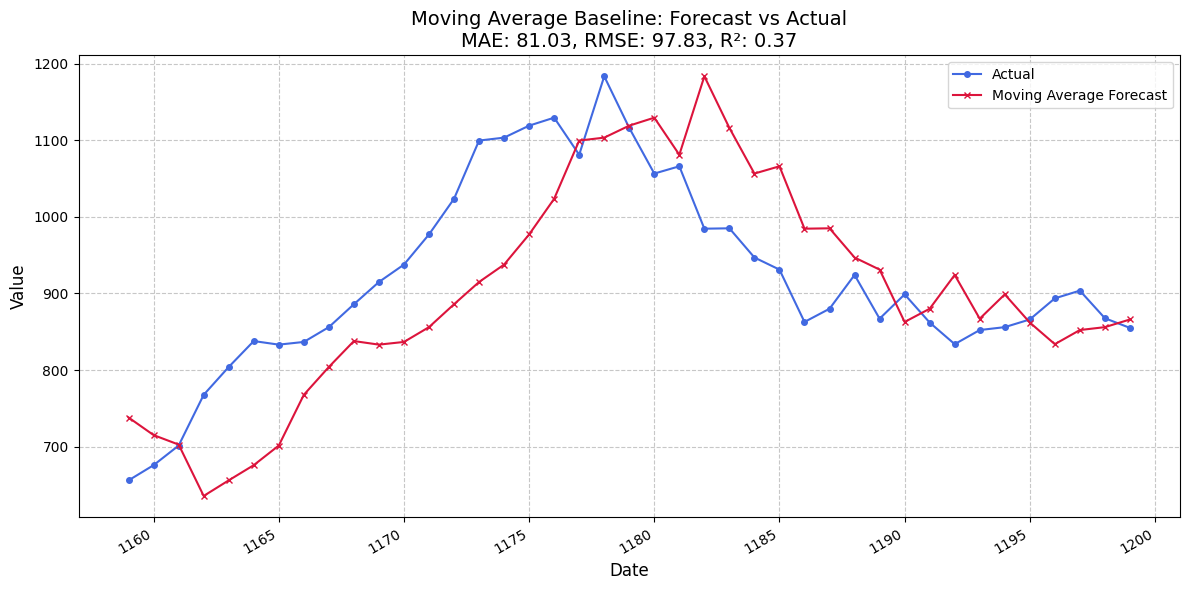

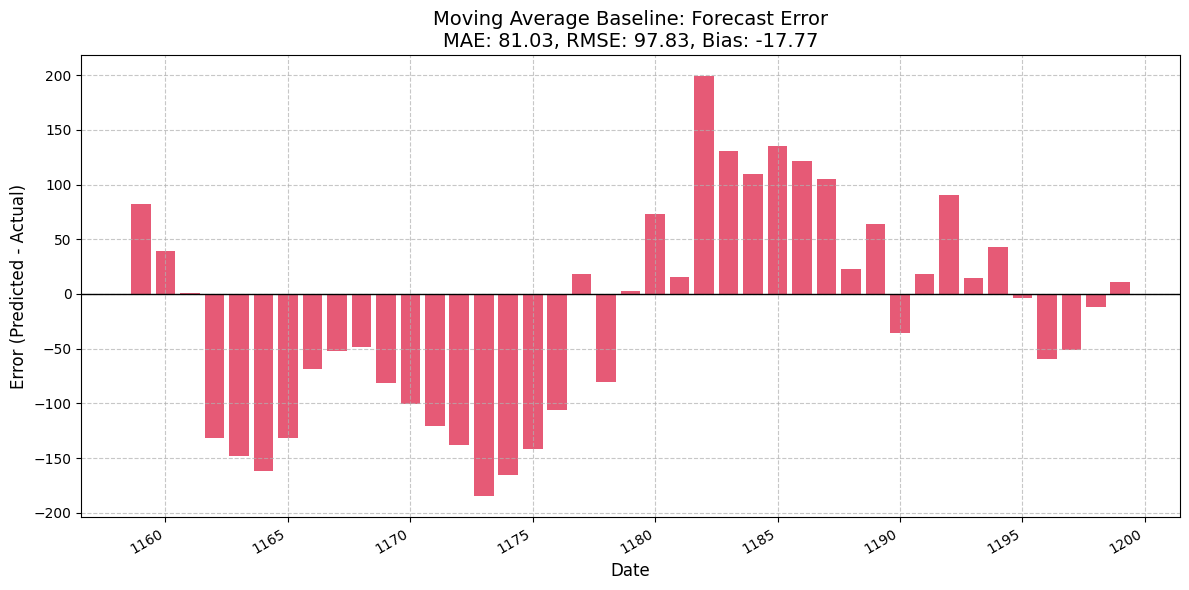

C:\Users\pedro\AppData\Local\Temp\ipykernel_26332\1422665855.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\pedro\AppData\Local\Temp\ipykernel_26332\1422665855.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


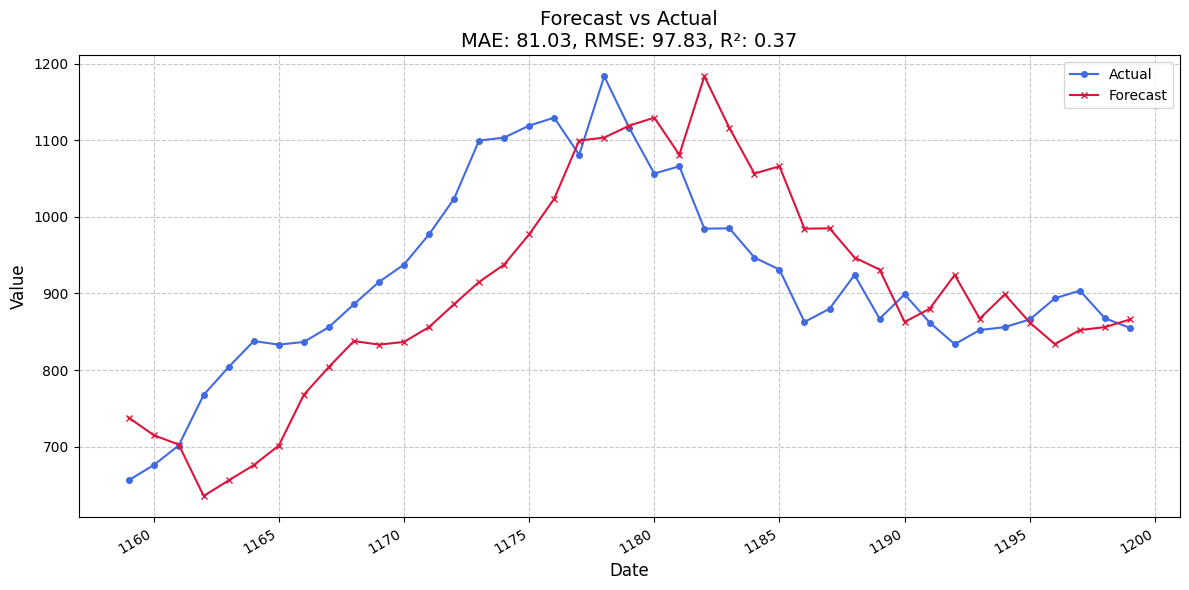

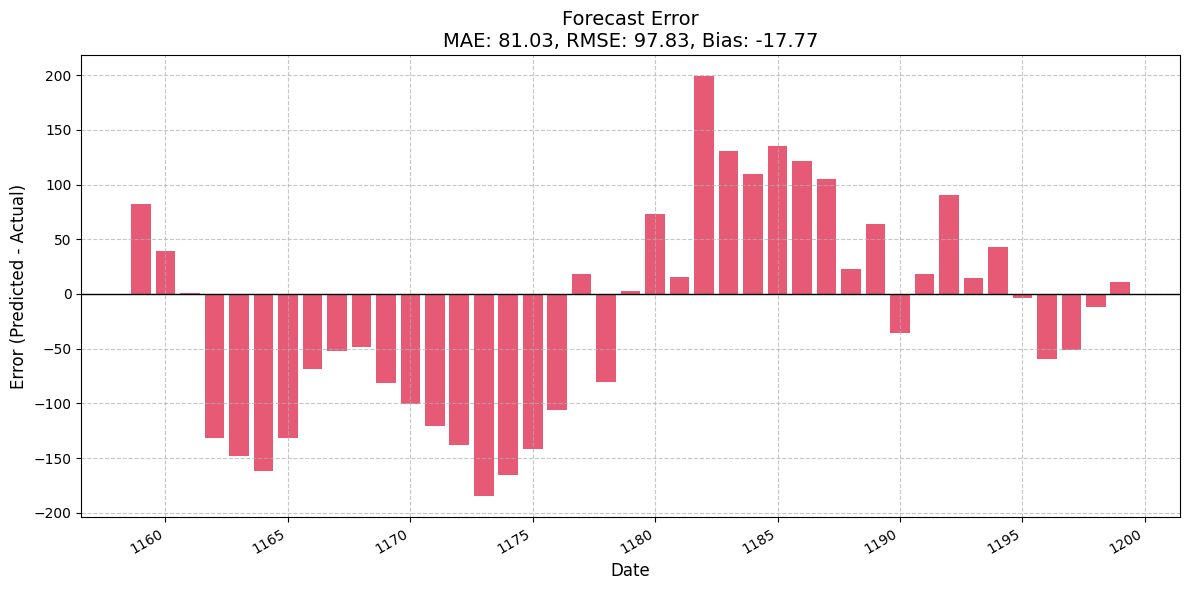

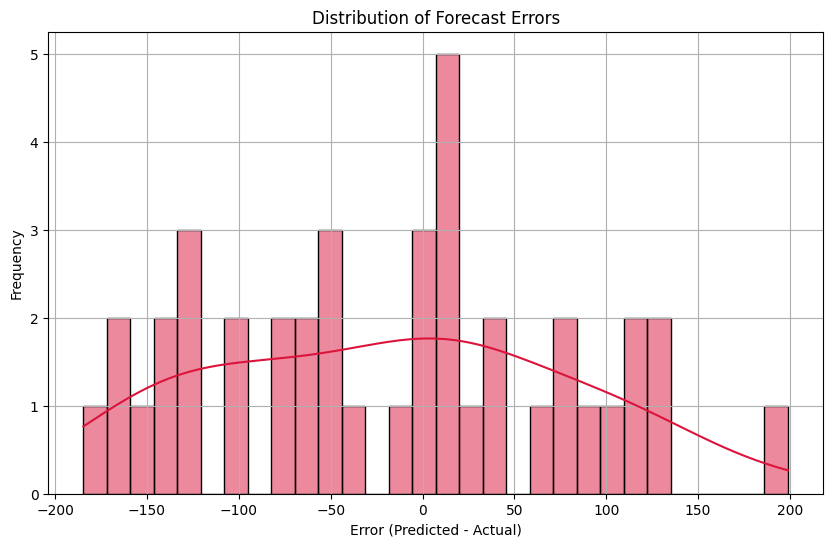

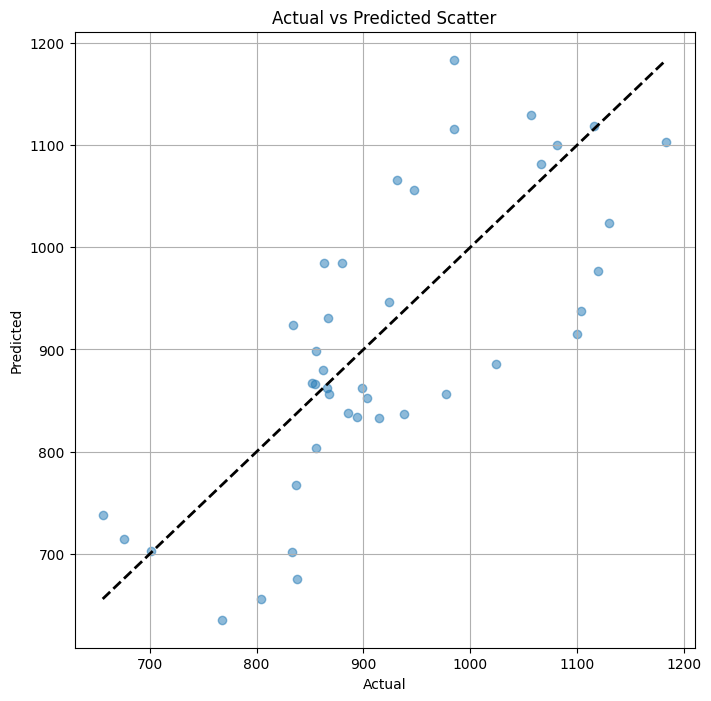

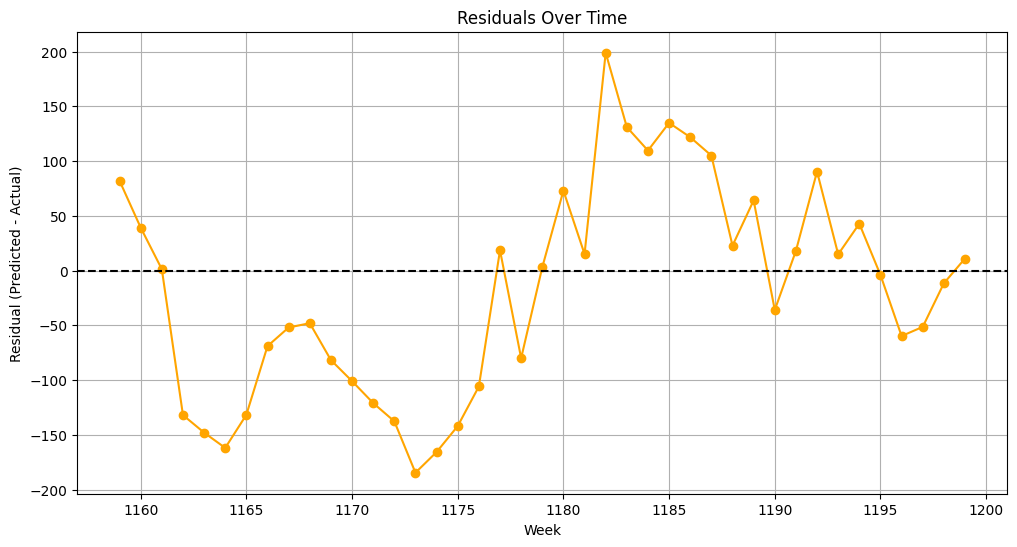

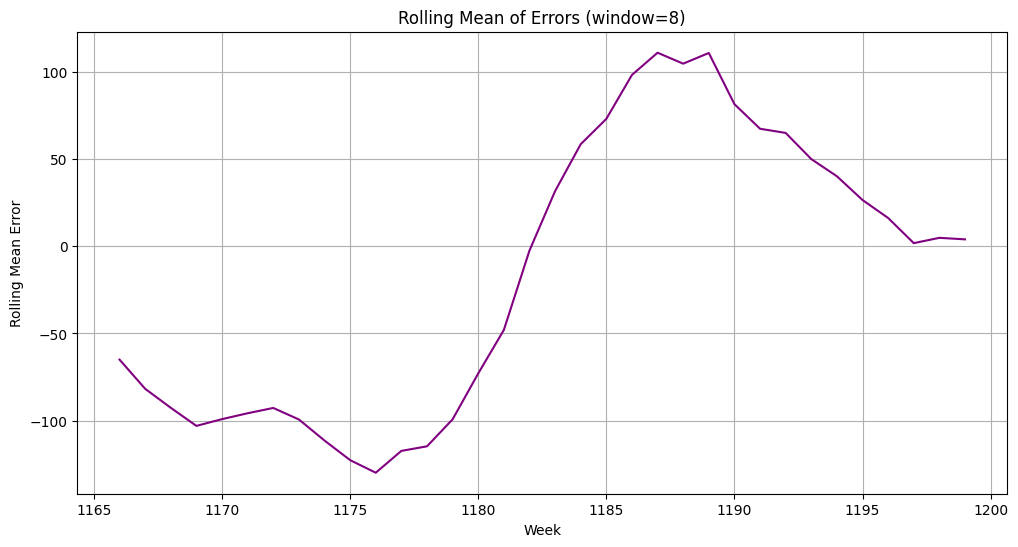

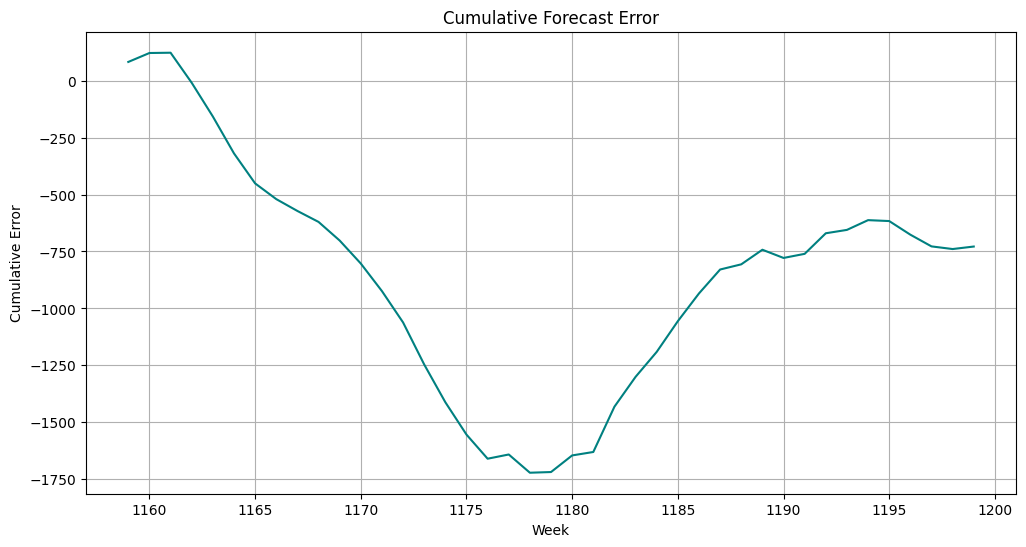

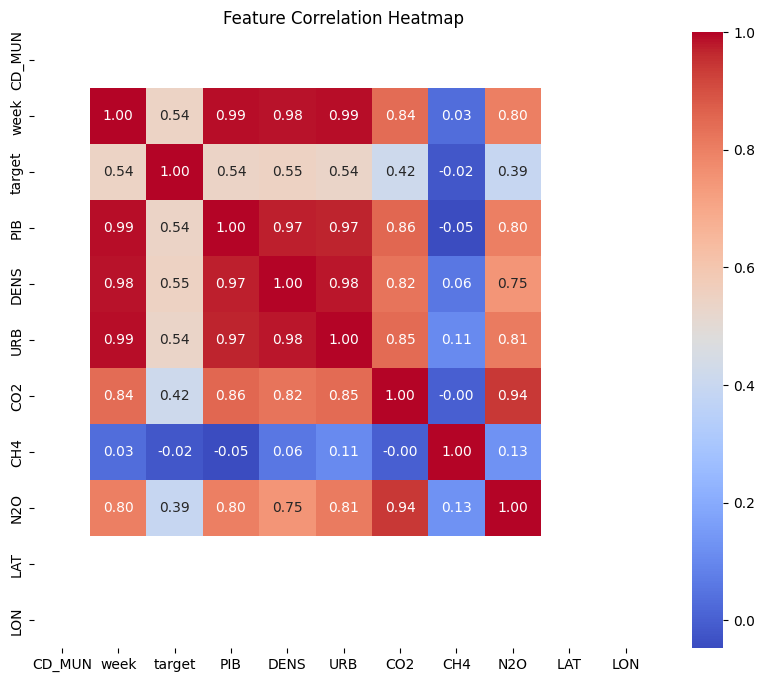

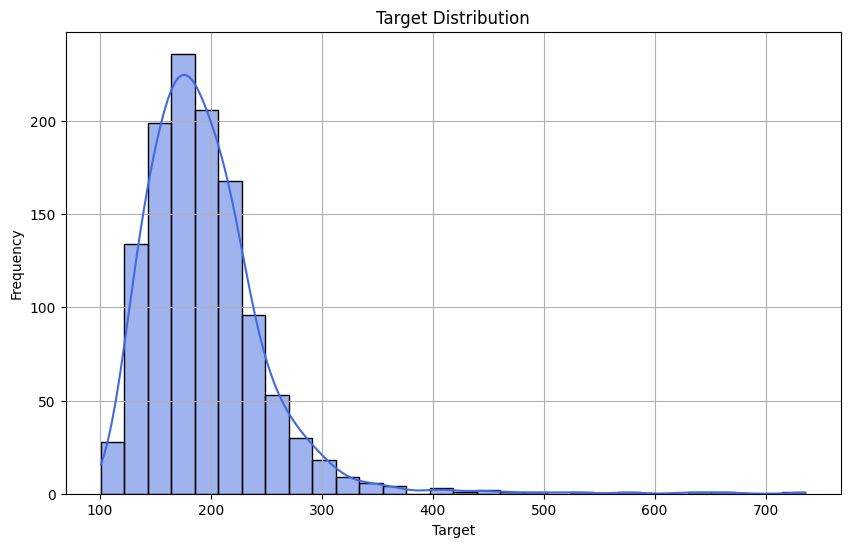

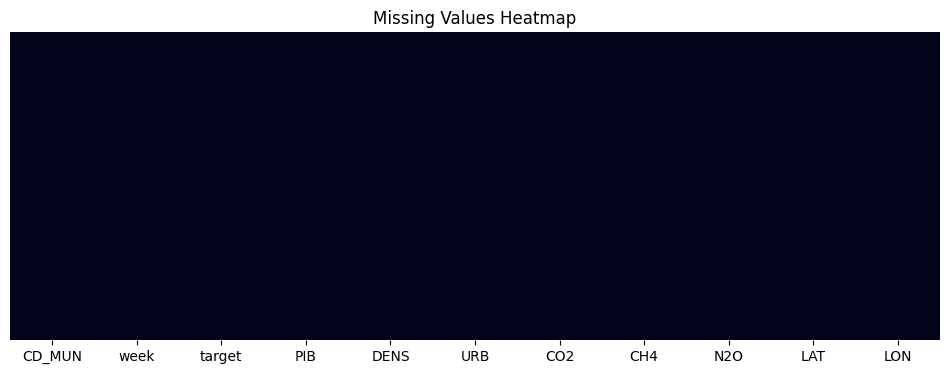

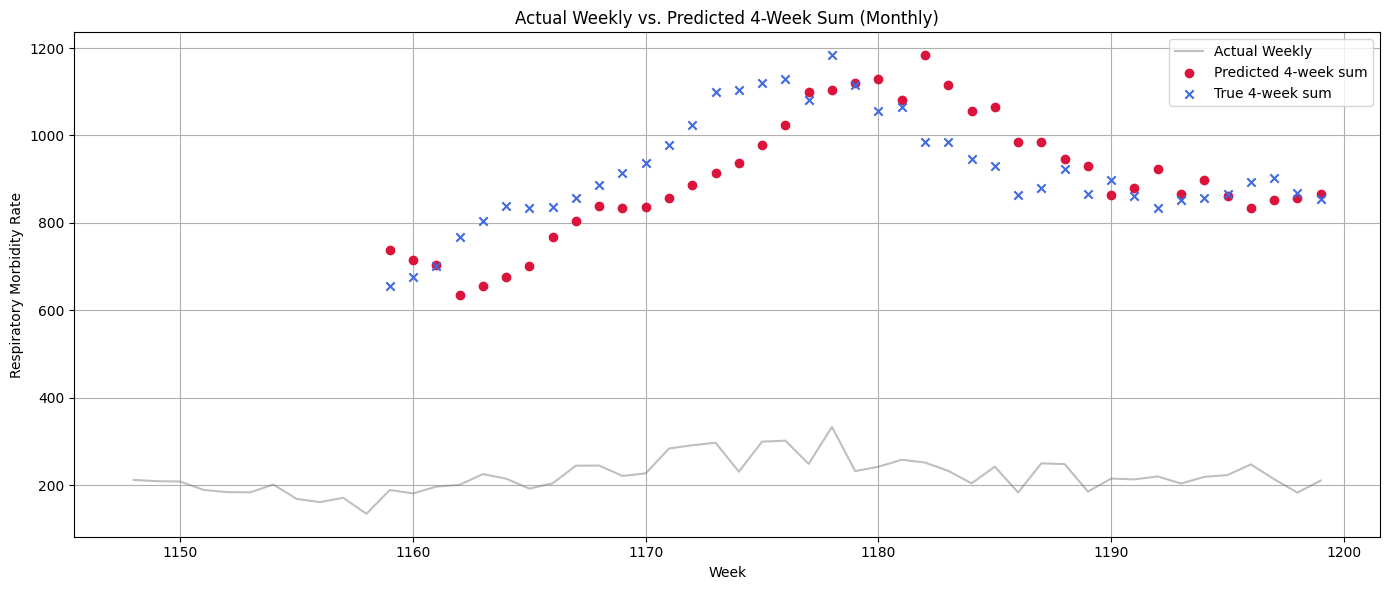

,week,y_test (sum next 4w),y_pred (sum next 4w)
0,1159,656.000000,738.000000
1,1160,675.847835,715.057753
2,1161,701.441203,702.681115
3,1162,767.659861,635.664409
4,1163,804.000000,656.000000
5,1164,837.811565,675.847835
6,1165,833.154526,701.441203
7,1166,836.668883,767.659861
8,1167,856.000000,804.000000
9,1168,885.885406,837.811565


In [7]:
# Get time axis for the test set
# Use 'week' if available, else integer index
if 'week' in test_df.columns:
    test_dates = test_df['week'].values[-len(y_test):]
else:
    test_dates = np.arange(len(y_test))

# Plot forecast vs actual
fig = plot_forecast(
    true_values=y_test,
    predictions=y_pred,
    dates=test_dates,
    title="Moving Average Baseline: Forecast vs Actual",
    true_label="Actual",
    pred_label="Moving Average Forecast"
)
plt.savefig(os.path.join(results_dir, 'forecast_plot.png'))
plt.show()

# Plot forecast error
fig = plot_forecast_error(
    true_values=y_test,
    predictions=y_pred,
    dates=test_dates,
    title="Moving Average Baseline: Forecast Error"
)
plt.savefig(os.path.join(results_dir, 'error_plot.png'))
plt.show()

# --- Advanced Evaluation and Visualization ---

# 1. Forecast vs Actual (already present)
fig1 = plot_forecast(y_test, y_pred, dates=test_df['week'][-len(y_test):], title="Forecast vs Actual")
fig1.show()

# 2. Forecast Error (already present)
fig2 = plot_forecast_error(y_test, y_pred, dates=test_df['week'][-len(y_test):], title="Forecast Error")
fig2.show()

# 3. Distribution of Errors
errors = y_pred - y_test
plt.figure(figsize=(10,6))
sns.histplot(errors, kde=True, bins=30, color='crimson')
plt.title('Distribution of Forecast Errors')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Scatter')
plt.grid(True)
plt.show()

# 5. Residuals Over Time
plt.figure(figsize=(12,6))
plt.plot(test_df['week'][-len(y_test):], errors, marker='o', linestyle='-', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Week')
plt.ylabel('Residual (Predicted - Actual)')
plt.grid(True)
plt.show()

# 6. Rolling Mean of Errors
window = 8
rolling_error = pd.Series(errors).rolling(window=window).mean()
plt.figure(figsize=(12,6))
plt.plot(test_df['week'][-len(y_test):], rolling_error, color='purple')
plt.title(f'Rolling Mean of Errors (window={window})')
plt.xlabel('Week')
plt.ylabel('Rolling Mean Error')
plt.grid(True)
plt.show()

# 7. Cumulative Error
cumulative_error = np.cumsum(errors)
plt.figure(figsize=(12,6))
plt.plot(test_df['week'][-len(y_test):], cumulative_error, color='teal')
plt.title('Cumulative Forecast Error')
plt.xlabel('Week')
plt.ylabel('Cumulative Error')
plt.grid(True)
plt.show()

# 8. Feature Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_city.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 9. Target Distribution
plt.figure(figsize=(10,6))
sns.histplot(df_city['target'], kde=True, bins=30, color='royalblue')
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 10. Missing Values Heatmap
plt.figure(figsize=(12,4))
sns.heatmap(df_city.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

# Overlay plot: Actual weekly series and predicted 4-week sum
plt.figure(figsize=(14,6))
plt.plot(test_df['week'], test_df['target'], label='Actual Weekly', color='gray', alpha=0.5)
plt.scatter(test_df['week'].values[-len(y_pred):], y_pred, label='Predicted 4-week sum', color='crimson', zorder=3)
plt.scatter(test_df['week'].values[-len(y_test):], y_test, label='True 4-week sum', color='royalblue', marker='x', zorder=3)
plt.title('Actual Weekly vs. Predicted 4-Week Sum (Monthly)')
plt.xlabel('Week')
plt.ylabel('Respiratory Morbidity Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Diagnostic: Check alignment of predictions and targets
import pandas as pd
N = 10
week_idx = test_df['week'].values[-len(y_test):]
df_diag = pd.DataFrame({
    'week': week_idx[:N],
    'y_test (sum next 4w)': y_test[:N],
    'y_pred (sum next 4w)': y_pred[:N]
})
display(df_diag)


## Save Results

Save the predictions and metrics for later comparison.

In [8]:
# Save predictions
preds_file = save_predictions(
    y_true=y_test,
    y_pred=y_pred,
    dates=test_dates,
    city_name='all',  # Using 'all' since we're using the combined dataset
    model_name='moving_average_baseline',
    output_dir=results_dir
)
print(f"Predictions saved to: {preds_file}")

# Save metrics
metrics_file = save_metrics(
    metrics=metrics,
    city_name='all',
    model_name='moving_average_baseline',
    output_dir=results_dir,
    params=model_params
)
print(f"Metrics saved to: {metrics_file}")


Predictions saved to: results\moving_average_baseline\all_moving_average_baseline_preds.csv
Metrics saved to: results\moving_average_baseline\all_moving_average_baseline_metrics.csv


## Conclusion

The Moving Average Baseline provides a simple, interpretable benchmark for forecasting monthly respiratory-morbidity rates. Its performance will be compared to more advanced models in subsequent notebooks.